# Quantitative Trading Model Using LSTM
#### Donovan Wood, James Ohr, Andre Xiao  
## Abstract
* What problem did we address?
* What approach(es) did we use to address it?
* What are the big-picture results?

We applied machine learning methods to predict daily stock price movements in a basket of 10 US-listed energy companies. We found the most success using an LSTM model, achieving an accuracy of up to 61% on one stock (PSX). In line with prior literature, we compared our results to a benchmark established by a last value machine, which simply predicts the next day's price to be the current day's actual price. Comparing our LSTM results to our benchmark, we find mixed results. 

## Introduction
* Prompt: "Your introduction should describe the big-picture problem that you aimed to address in your project. What’s the problem to be solved, and why is it important? Who has tried solving this problem already, and what did they do? I would expect most introductions to reference no fewer than 2 scholarly studies that attempted similar tasks, although 5 is probably a better target."

In this blog post, we train machine learning models on historical stock market data to predict future stock price movements. This is a highly popular problem to address because of the potential for significant monetary gain. This is an important problem societally because stock markets are mechanisms of price discovery: they answer the question "What is a company worth?" Finding the right answer to that question allows society to correctly allocate more or less capital (money) to that company. On an individual level, this is an important problem to us as the authors because it's the problem for all quant trading: making a profitable model. 

An enormous body of literature within and without computer science exists for stock market prediction. Among the papers most relevant to our work are @gunduzEfficientPrediction2021, @bhandariLSTM2022, and @zhangPrediction2022.

@gunduzEfficientPrediction2021 applies LSTM and ensemble learning (Light-GBM) models to predict the hourly directions of eight banking stocks in Borsa Istanbul. He achieved up to maximum success rate of 0.685 using individual features of bank stocks and LSTM.

@bhandariLSTM2022 apply single-layer and multi-layer LSTM models to the problem of predicting the S&P 500, the index of the largest 500 publicly traded companies in America. Their single-layer LTSM model with 150 neurons is their best performing specification. Their set of predicted values have an average correlation coefficient of 0.9976 with actual S&P index values.

@zhangPrediction2022 finds the LSTM network model does not perform better than other models when applied to a short forecasting horizon (1 to 10 days). Zhang's "other models" are linear regression, eXtreme gradient boosting (XGBoost), last value, and moving average.

We take some of the "best practices" we observe in the above papers, specifically benchmarking with last value and calculating accuracy with R, RMSE, and MAPE. Unlike the mentioned papers, we will be focusing on single stocks and attempting to build a model that outperforms the last value benchmark.

## Values

The potential users are anyone interested in making profitable trades in the stock market. They are the individuals most likely to directly benefit from our work. Nonusers who could be affected by our work are those engaged in the stock market. The obvious affected nonusers are those on the opposite side of each trade as a user. In every trade, there's a buyer and a seller, so in every trade, there's a winner and a loser. These opposing nonusers are the individuals who are most likely to be harmed by the success of our program. 

Ultimately, the point of the back and forth of markets is price discovery: to help society find the right prices of different companies. This leads to another nonuser effect: with better price discovery and more efficient markets, companies will raise money at prices that are closer to some "true" value, which is loosely defined as a value that best reflects the fundamental valuation of the company. Our model does not attempt to predict a true fundamental value for a company, but by making accurate predictions for the next day's price, it should accelerate the market's convergence to an appropriate value.

A useful financial trading model should lead to a net societal benefit because better financial markets mean more or less money going to companies and therefore projects, leading to something closer to an "optimal" allocation of money in society.

We are personally motivated to work on this project because of personal interest, professional relevance, and the difficulty of the problem. All three of us personally invest in the stock market. Two of us (Donovan & James) are double majors in economics and have had experience working in the financial services industry. Andre is interested in pursuing a master's in financial engineering after Middlebury. The problem itself is also inherently challenging: financial markets are constantly adapting and changing, making the findings of previous literature increasingly likely over time to be less applicable to today's markets. This forces us to adopt new techniques. 
# Materials and Methods 

## Our Data 

Our data was sourced from Yahoo Finance. We used the `yfinance` library to download historical stock price data for our 10 different stocks. We chose to focus on US-based oil companies. These companies are Exxon Mobil (XOM), Chevron (CVX), ConocoPhillips (COP), Enterprise Products Partners (EPD), Pioneer Natural Resources (PXD), EOG Resources (EOG), Duke Energy (DUK), Marathon Petroleum (MPC), Schlumberger (SLB), and Phillips 66 (PSX). We downloaded the data from May 6th, 2014 to May 6th, 2024. 

Within the `yfinance` dataset we were given the following columns: `Open`, `High`, `Low`, `Close`, `Adj Close`, `Volume`.

`Open` is the opening price of the stock for the day. 
`High` is the highest price of the stock for the day. 
`Low` is the lowest price of the stock for the day. 
`Close` is the closing price of the stock for the day. 
`Adj Close` is the adjusted closing price of the stock for the day. 
`Volume` is the number of shares traded for the day.

 We used the `Close` column as our target variable for our model. We also created the following features: `SMA_20`, `SMA_50`, `Std_Dev`, `Z_Score`, `RSI`, `TTM_P/E` which will be discussed below. Here's a look at what the raw data looks like:

In [1]:
#| echo: false

from torch.autograd import Variable 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.autograd import Variable 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import torch

In [2]:
import yfinance as yf

xom = yf.Ticker('XOM')
data = xom.history(start='2014-05-06', end='2024-05-07')
data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-05-06 00:00:00-04:00,66.050601,66.501242,65.928289,66.095665,9669800,0.00,0.0
2014-05-07 00:00:00-04:00,66.385338,66.597777,66.172893,66.378899,11007400,0.00,0.0
2014-05-08 00:00:00-04:00,66.366045,66.494802,65.773780,65.870346,8922500,0.00,0.0
2014-05-09 00:00:00-04:00,65.922184,66.226810,65.630524,66.077736,8948800,0.69,0.0
2014-05-12 00:00:00-04:00,66.324060,66.337020,65.805547,66.259247,8830500,0.00,0.0


You can find the full implementation of our data at [lstm_data.py](./lstm_data.py) under the function `prepare_data()`.

## Our Approach

### Features of Our Data & Target Variable

We used `SMA_20`, `SMA_50`, `Std_Dev`, `Z_Score`, `RSI`, `Close`, `TTM_P/E` as predictors for our models. 

The `SMA_20` and `SMA_50` are the 20-day and 50-day simple moving averages of the stock price. This means that the average closing price of the stock over the last 20 and 50 days, respectively.

 The `Std_Dev` is the standard deviation of the stock price meaning how much the stock price deviates from the mean.
 
 The `Z_Score` is the z-score of the stock price meaning how many standard deviations the stock price is from the mean.
 
 The `RSI` is the relative strength index of the stock price meaning how strong the stock price is relative to its past performance. It is calculated by taking the average of the gains and losses over a certain period of time.
 
 The `Close` is the closing price of the stock per day. 
 
 The `TTM_P/E` is the trailing twelve months price-to-earnings ratio of the stock.

We used the next day's `Close` price as the target variable for our model.

### Data Manipulation

We collected 10 years of data from May 7th, 2014 to May 7th, 2024 and used a train-test split of 90-10 in order to train our model on the first 9 years worth of the data and test it on the remaining 1 year's worth of data. We used a standard scaler for scaling our data in order to ensure that the data was normalized. We fit the scaler on the training data and then applied it to the test data to avoid any information leaking. We then combined the training data for each stock into one dataset. We used the closing price of the stock as the target variable for our model. 

Here's what our data looks like after creating our features and scaling the data:


In [3]:
#| echo: false

%load_ext autoreload
%autoreload 2
from lstm_model import LSTMModel
from lstm_data import prepare_data, evaluate_lstm

In [4]:
tickers = ['XOM', 'CVX', 'COP', 'EPD', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX', 'PXD']
start = '2014-05-06'
end = '2024-05-07'

# preps data, see lstm_data.py, prints size of each ticker's dataset
X_train, y_train, X_test, y_test, X_scalers, y_scalers, batch_size = prepare_data(tickers, start_date=start, end_date=end, test_size=0.1)
X_train

(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2041, 18)
(2039, 18)


,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_10,SMA_20,SMA_50,SMA_100,SMA_250,Std_Dev,Z_Score,RSI,TTM_EPS,TTM_P/E,Returns,Ticker
2015-05-01,-0.139877,-0.131186,-0.112171,-0.102372,-0.540891,-0.127836,0.0,-0.149378,-0.173825,-0.178037,-0.063809,0.319177,-0.679902,1.186544,0.879788,0.650885,-0.095652,0.893769,XOM
2015-05-04,-0.080168,-0.096256,-0.064154,-0.092512,-0.732495,-0.127836,0.0,-0.142219,-0.166130,-0.178686,-0.064625,0.316818,-0.653449,1.177780,0.973547,0.650885,-0.095424,0.133766,XOM
2015-05-05,-0.059252,-0.088369,-0.080672,-0.111474,-0.577151,-0.127836,0.0,-0.135596,-0.160600,-0.179007,-0.065519,0.314254,-0.642312,0.791831,0.671993,0.650885,-0.095861,-0.329246,XOM
2015-05-06,-0.071420,-0.093251,-0.108714,-0.127399,-0.639387,-0.127836,0.0,-0.132801,-0.152615,-0.179993,-0.065441,0.311766,-0.751691,0.518644,0.427507,0.650885,-0.096229,-0.281967,XOM
2015-05-07,-0.134173,-0.163112,-0.142135,-0.149774,-0.767664,-0.127836,0.0,-0.132571,-0.146911,-0.181595,-0.065841,0.309079,-0.859101,0.047922,0.100187,0.650885,-0.096744,-0.387771,XOM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-31,1.493992,1.492097,1.543915,1.492743,0.823977,9.866377,0.0,1.628988,1.646565,1.783051,1.907624,2.559939,-0.559921,-1.147405,-0.892991,2.509161,0.151639,-0.654974,PXD
2023-06-01,1.483391,1.512614,1.526955,1.524836,-0.437747,-0.065789,0.0,1.629326,1.642216,1.787301,1.901785,2.554111,-0.530308,-0.787139,-0.702119,2.509161,0.151895,0.228344,PXD
2023-06-02,1.599061,1.610538,1.646389,1.639757,-0.099743,-0.065789,0.0,1.641226,1.645750,1.796633,1.898004,2.548417,-0.533017,0.224675,-0.082585,2.509161,0.152809,0.865681,PXD
2023-06-05,1.714025,1.615900,1.641850,1.573211,-0.521622,-0.065789,0.0,1.634785,1.638631,1.804880,1.893255,2.542460,-0.573249,-0.327880,-0.394452,2.509161,0.152280,-0.522197,PXD


### Models We Employed

Originally, we used rather simplistic models like logistic regression, Random Forest, and SVM in order to predict stock price movements. We utilized Recursive Feature Elimination (RFE) in order to determine the optimal features for prediction for each model. However, we found that these models were not able to predict stock price movements consistently with much accuracy. We then decided to use a Long Short-Term Memory (LSTM) model to predict stock price movements. `LSTM` models are a type of recurrent neural network (RNN) with the addition of "gates" notably the `input`, `forget` and `output` gates. These gates allow for the model to determine what information to retain or discard at each timestep, mitigating the vanishing descent issue found in traditional recurrent neural networks. The LSTM model accounts for the shortfalls of an RNN by capturing long-term dependencies in the data.

The forget gate determines which information is either retained or discarded at each time step. It accepts the output from the previous time step $h_{t-1}$ and the input $x_t$ at the current time step. The forget gate is defined as:

$$f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f)$$

The input gate determines which information is stored in the cell state. It avoids feeding the unimportant information into the current memory cell. It has three different components: 

1) Getting the state of the cell that must be updated.
2) Create a new cell state
3) Update the cell state to the current cell state

These are defined as: 

\begin{aligned}
i_{t} &= \sigma(W_{t} \cdot [h_{t-1}, x_{t}] + b_{i}) \\
\widetilde{C}_{t} &= \tanh(W_{c} \cdot [h_{t-1}, x_{t}] + b_{c}) \\
C_{t} &= f_{t} \ast C_{t-1} + i_{t} \ast \widetilde{C}_{t}
\end{aligned}

The output gate determines how much of the newly created cell state will be discarded and how much will be passed to the output. It is defined as:

$$o_{t} = \sigma(W_{o} \cdot [h_{t-1}, x_{t}] + b_{o})$$

This output information is firstly determined by a sigmoid layer, then the newly created cell state is processed by a tanh layer. The output is then multiplied by the sigmoid layer to determine the final output of the LSTM cell.

Which is defined as:

$$h_{t} = o_{t} \ast \tanh(C_{t})$$

Taking this all into account, the LSTM model is able to retain information from previous time steps and use it to predict future stock price movements while disregarding irrelevant information.

The implementation of our LSTM model can be found at: [lstm_model.py](./lstm_model.py)

### Training Our Models

We first converted our wanted feature columns into a `torch` `Variable` to allow them to be differentiable. Then, we reshaped the data using `torch.reshape()` and `torch.utils.data.DataLoader` into `[batch_size, seq_len, input_size]`. 

In [5]:
features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E']

X_train_tensors = Variable(torch.Tensor(np.array(X_train[features])))
y_train_tensors = Variable(torch.Tensor(y_train.values))
X_train_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))

# split data by ticker
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=True
)

next(iter(data_loader_train))[0].shape

torch.Size([2041, 1, 7])


We trained our model using our own personal devices. We used the `Adam` optimizer with a learning rate of 0.001. We trained the model for 1000 epochs for each stock in our dataset (10 total) and used the `torch.nn.MSELoss()` loss function to train the model.

MSE is defined as:

$$MSE = \frac{1}{n} \sum_{i=1}^{n} (\hat{y}_{i} - y_{i})^2$$

Where $y_{i}$ is the true price and $\hat{y}_{i}$ is the predicted price.

As mentioned previously our model was trained on 90% of the data and tested on the remaining 10%.

If the model predicted the next days price to be positive, we would purchase the stock at the closing price and sell it at the closing price the next day. If the model predicted the next days price to be negative, we would short the stock at the closing price and buy it back at the closing price the next day. We would then calculate the profit or loss percent change for each stock and compare it to the last value benchmark. 

In [6]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
window = 1 # number of windows, leave at 1, basically can ignore

num_classes = 1 # number of output classes

lstm = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate) # ADAM optimizer

# training loop
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.86365
Epoch: 100, loss: 0.00496
Epoch: 200, loss: 0.00481
Epoch: 300, loss: 0.00548
Epoch: 400, loss: 0.00480
Epoch: 500, loss: 0.00520
Epoch: 600, loss: 0.00487
Epoch: 700, loss: 0.00503
Epoch: 800, loss: 0.00487
Epoch: 900, loss: 0.00485


### Model Evaluation

We evaluated our model by comparing the cumulative predicted stock price returns and accuracy to the actual cumulative stock price returns and accuracy and the cumulative last value benchmark returns and accuracy. The last value benchmark is defined as using the previous days value as the prediction for the current day. We would buy the stock at the current day's close price and sell at the next day's close price if the predicted returns were positive and do nothing if the predicted returns were negative. We followed the same principle in calculating actual cumulative stock returns and accuracy, and the cumulative last value benchmark returns and accuracy.

**Accuracy per Stock**

In [16]:
#| code-fold: true

for i in range(10):
    cum_strat_returns, cum_stock_returns, cum_lv_returns, accuracy, lv_accuracy = evaluate_lstm(lstm, X_test[i], y_test[i], X_scalers[i], y_scalers[i], features)
    if i == 0:
        cum_strat_returns_list = np.array([cum_strat_returns])
        cum_stock_returns_list = np.array([cum_stock_returns])
        cum_lv_returns_list = np.array([cum_lv_returns])
        accuracy_list = np.array([accuracy])
        lv_accuracy_list = np.array([lv_accuracy])
    else:
        cum_strat_returns_list = np.append(cum_strat_returns_list, np.array([cum_strat_returns]), axis=0)
        cum_stock_returns_list = np.append(cum_stock_returns_list, np.array([cum_stock_returns]), axis=0)
        cum_lv_returns_list = np.append(cum_lv_returns_list, np.array([cum_lv_returns]), axis=0)
        accuracy_list = np.append(accuracy_list, np.array([accuracy]), axis=0)
        lv_accuracy_list = np.append(lv_accuracy_list, np.array([lv_accuracy]), axis=0)

XOM Accuracy: 0.5374449339207048, Last Value Benchmark: 0.5242290748898678
CVX Accuracy: 0.5110132158590308, Last Value Benchmark: 0.5066079295154186
COP Accuracy: 0.5594713656387665, Last Value Benchmark: 0.5418502202643172
EPD Accuracy: 0.5242290748898678, Last Value Benchmark: 0.5286343612334802
EOG Accuracy: 0.5462555066079295, Last Value Benchmark: 0.5462555066079295
DUK Accuracy: 0.4889867841409692, Last Value Benchmark: 0.4933920704845815
MPC Accuracy: 0.5814977973568282, Last Value Benchmark: 0.5462555066079295
SLB Accuracy: 0.4713656387665198, Last Value Benchmark: 0.4713656387665198
PSX Accuracy: 0.6255506607929515, Last Value Benchmark: 0.6123348017621145
PXD Accuracy: 0.5286343612334802, Last Value Benchmark: 0.5110132158590308


**Average Accuracy**

In [17]:
#| code-fold: true

print(f'Avg Accuracy: {accuracy_list.mean()}, Avg LV Benchmark: {lv_accuracy_list.mean()}')

Avg Accuracy: 0.5374449339207048, Avg LV Benchmark: 0.528193832599119


**Cumulative Returns**

1 Year Portfolio Returns: 1.2828554283607414
1 Year Stock Returns: 1.23067952784646
1 Year LV Returns: 1.1996890945830683


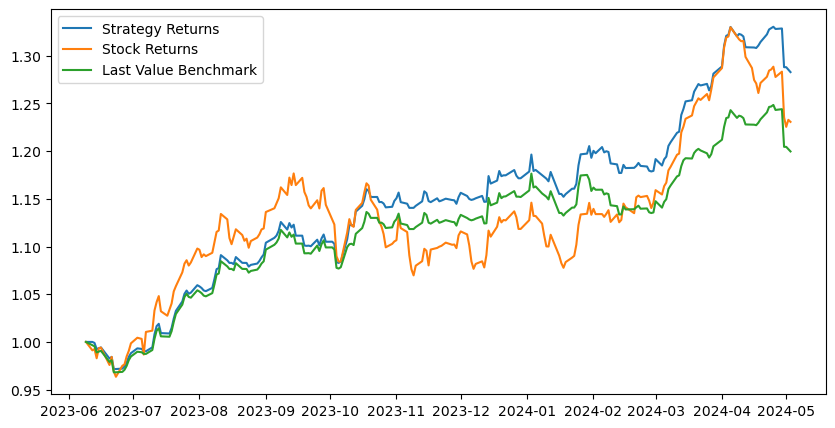

In [15]:
#| code-fold: true
#| fig-cap: A comparison of cumulative returns between our strategy returns, baseline stock returns, and the last value benchmark.
#| label: fig-returns

df_strat_returns = pd.DataFrame(cum_strat_returns_list.transpose(), columns=tickers)
df_strat_returns['Cum_Strat_Returns'] = df_strat_returns.mean(axis=1)
df_strat_returns.index = X_test[0].index

df_stock_returns = pd.DataFrame(cum_stock_returns_list.transpose(), columns=tickers)
df_stock_returns['Cum_Stock_Returns'] = df_stock_returns.mean(axis=1)
df_stock_returns.index = X_test[0].index

df_lv_returns = pd.DataFrame(cum_lv_returns_list.transpose(), columns=tickers)
df_lv_returns['Cum_LV_Returns'] = df_lv_returns.mean(axis=1)
df_lv_returns.index = X_test[0].index

total_strat_returns = df_strat_returns['Cum_Strat_Returns'].iloc[-1]
total_stock_returns = df_stock_returns['Cum_Stock_Returns'].iloc[-1]
total_lv_returns = df_lv_returns['Cum_LV_Returns'].iloc[-1]

print(f'1 Year Portfolio Returns: {total_strat_returns}')
print(f'1 Year Stock Returns: {total_stock_returns}')
print(f'1 Year LV Returns: {total_lv_returns}')

plt.figure(figsize=(10,5))
plt.plot(df_strat_returns['Cum_Strat_Returns'], label='Strategy Returns')
plt.plot(df_stock_returns['Cum_Stock_Returns'], label='Stock Returns')
plt.plot(df_lv_returns['Cum_LV_Returns'], label='Last Value Benchmark')
plt.legend();

## Live Mock Testing

In [ ]:
from sklearn.preprocessing import StandardScaler

start = '2014-05-06'
end = '2024-05-08'


X_train_list = []
y_train_list = []
X_test_list = []
y_test_list = []
X_scalers = []
y_scalers = []
for t in tickers:
    ticker_data = yf.Ticker(t)
    #data = ticker_data.history(period=period)
    data = yf.download(t, start=start, end=end)

    # Calculate moving averages and std
    data['SMA_20'] = data['Close'].rolling(window=20).mean()
    data['SMA_50'] = data['Close'].rolling(window=50).mean()
    data['Std_Dev'] = data['Close'].rolling(window=20).std()

    # Calculate the z-score
    data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

    # Calculate RSI
    delta = data['Close'].diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ema_up = up.ewm(com=13, adjust=False).mean()
    ema_down = down.ewm(com=13, adjust=False).mean()
    rs = ema_up / ema_down

    data['RSI'] = 100 - (100 / (1 + rs))
    # Calculate TTM EPS and P/E
    eps = ticker_data.get_earnings_dates(limit=60)
    eps.index = eps.index.date
    eps = eps.loc[~eps.index.duplicated(keep='first'), :]
    data.index = data.index.date
    eps = eps[(eps.index >= (data.index[0]-relativedelta(years=1))) & (eps.index <= data.index[-1])]
    if t == 'DUK':
        eps.loc[eps.index == pd.to_datetime('2024-05-07').date(), 'Reported EPS'] = 1.44
    eps = eps.iloc[::-1]
    eps['TTM'] = eps['Reported EPS'].rolling(window=4).sum()
    
    idx = pd.date_range(eps.index[0], eps.index[-1])
    eps = eps.reindex(idx.date, fill_value=np.nan)
    data['TTM_EPS'] = eps['TTM'].copy()
    data[data['TTM_EPS'].notna()]
    data['TTM_EPS'] = data['TTM_EPS'].ffill()
    data['TTM_EPS'] = data['TTM_EPS'].fillna(eps['TTM'].loc[eps['TTM'].notna()].iloc[0])
    data['TTM_P/E'] = data['Close'] / data['TTM_EPS']

    # Calculate the daily returns
    data['Returns'] = data['Close'].pct_change()

    # Drop any NaNs

    # If stock price goes up or down
    data['Target'] = data['Close'].shift(-1)

    data = data.dropna()
    #features = ['Ticker', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
    X = data.loc[:, data.columns != 'Target']
    y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]
    #X = X.dropna()
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
    
    ss1 = StandardScaler()
    ss2 = StandardScaler()

    X_train_ss = pd.DataFrame(ss1.fit_transform(X), index=X.index, columns=X.columns) # fit ss and transform X_train
    y_train_ss = pd.DataFrame(ss2.fit_transform(y), index=y.index, columns=y.columns) # fit mm and transform y_train

    X_train_ss['Ticker'] = t
    print(X_train_ss.shape)
    X_train_list.append(X_train_ss)
    y_train_list.append(y_train_ss)
    X_scalers.append(ss1)
    y_scalers.append(ss2)
batch_size = X_train_list[0].shape[0]

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)



[*********************100%%**********************]  1 of 1 completed


(2469, 15)
(2469, 15)


In [ ]:
X_train = pd.concat(X_train_list)
y_train = pd.concat(y_train_list)

features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E']

X_train_tensors = Variable(torch.Tensor(np.array(X_train[features])))
y_train_tensors = Variable(torch.Tensor(y_train.values))
X_train_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))


In [ ]:
num_epochs = 1000 # 1000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = X_train_final.shape[2] # number of features
hidden_size = 32 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers
batch_size = batch_size
window = 1 # number of windows, leave at 1, basically can ignore

num_classes = 1 # number of output classes

In [ ]:
# split data by ticker
data_loader_train = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(X_train_final, y_train_tensors),
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
lstm_live = LSTMModel(num_classes, input_size, hidden_size, num_layers, seq_length=window, batch_size=batch_size) #our lstm class 
criterion = torch.nn.MSELoss()    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm_live.parameters(), lr=learning_rate) # ADAM optimizer

In [ ]:
for epoch in range(num_epochs):
  for i, data in enumerate(data_loader_train):
    X_, y_ = data
    outputs = lstm_live.forward(X_) #forward pass
    optimizer.zero_grad() #calculate the gradient, manually setting to 0
  
    # obtain the loss function
    loss = criterion(outputs, y_.reshape(y_.size(0)*y_.size(1), 1))
  
    loss.backward() #calculates the loss of the loss function
  
    optimizer.step() #improve from loss, i.e backprop
    # if (i + 1) % 50 == 0:
    #     print(f"Epoch {epoch}, batch {i:>3}, loss on batch: {loss.item():.3f}")
  if epoch % 100 == 0:
    print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.94554
Epoch: 100, loss: 0.00529
Epoch: 200, loss: 0.00556
Epoch: 300, loss: 0.00527
Epoch: 400, loss: 0.00546
Epoch: 500, loss: 0.00539
Epoch: 600, loss: 0.00489
Epoch: 700, loss: 0.00583
Epoch: 800, loss: 0.00503
Epoch: 900, loss: 0.00533


In [ ]:
from joblib import dump, load

In [ ]:
dump(lstm_live, 'lstm.joblib')

In [ ]:
from sklearn.preprocessing import StandardScaler
df_pred_list = []
for j in range(7, 10):
    tickers = ['XOM', 'CVX', 'COP', 'NEE', 'SO', 'EOG', 'DUK', 'MPC', 'SLB', 'PSX']
    start = '2014-05-06'
    end = f'2024-05-0{j}'

    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    X_scalers = []
    y_scalers = []
    for t in tickers:
        ticker_data = yf.Ticker(t);
        #data = ticker_data.history(period=period)
        data = yf.download(t, start=start, end=end);

        # Calculate moving averages and std
        data['SMA_20'] = data['Close'].rolling(window=20).mean()
        data['SMA_50'] = data['Close'].rolling(window=50).mean()
        data['Std_Dev'] = data['Close'].rolling(window=20).std()

        # Calculate the z-score
        data['Z_Score'] = (data['Close'] - data['SMA_20']) / data['Std_Dev']

        # Calculate RSI
        delta = data['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        ema_up = up.ewm(com=13, adjust=False).mean()
        ema_down = down.ewm(com=13, adjust=False).mean()
        rs = ema_up / ema_down

        data['RSI'] = 100 - (100 / (1 + rs))
        # Calculate TTM EPS and P/E
        eps = ticker_data.get_earnings_dates(limit=60)
        eps.index = eps.index.date
        eps = eps.loc[~eps.index.duplicated(keep='first'), :]
        data.index = data.index.date
        eps = eps[(eps.index >= (data.index[0]-relativedelta(years=1))) & (eps.index <= data.index[-1])]
        if t == 'DUK':
            eps.loc[eps.index == pd.to_datetime('2024-05-07').date(), 'Reported EPS'] = 1.44
        eps = eps.iloc[::-1]
        eps['TTM'] = eps['Reported EPS'].rolling(window=4).sum()
        
        
        idx = pd.date_range(eps.index[0], eps.index[-1])
        eps = eps.reindex(idx.date, fill_value=np.nan)
        data['TTM_EPS'] = eps['TTM'].copy()
        data[data['TTM_EPS'].notna()]
        data['TTM_EPS'] = data['TTM_EPS'].ffill()
        data['TTM_EPS'] = data['TTM_EPS'].fillna(eps['TTM'].loc[eps['TTM'].notna()].iloc[0])
        data['TTM_P/E'] = data['Close'] / data['TTM_EPS']

        #X_test_list.append(data.iloc[-1])

        # Calculate the daily returns
        data['Returns'] = data['Close'].pct_change()

        # Drop any NaNs

        # If stock price goes up or down
        data['Target'] = data['Close'].shift(-1)

        #data = data.dropna()
        #features = ['Ticker', 'SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Returns']
        X = data.loc[:, data.columns != 'Target']
        y = data.iloc[:, (data.shape[1]-1):(data.shape[1])]
        X = X.dropna()
        #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=False)
        
        ss1 = StandardScaler()
        ss2 = StandardScaler()

        X_test_ss = pd.DataFrame(ss1.fit_transform(X), index=X.index, columns=X.columns) # fit ss and transform X_train
        y_test_ss = pd.DataFrame(ss2.fit_transform(y), index=y.index, columns=y.columns) # fit mm and transform y_train

        X_test_ss['Ticker'] = t
        print(X_train_ss.shape)
        X_test_list.append(X_test_ss)
        y_test_list.append(y_test_ss)
        X_scalers.append(ss1)
        y_scalers.append(ss2)
    batch_size = X_test_list[0].shape[0]

    features = ['SMA_20', 'SMA_50', 'Std_Dev', 'Z_Score', 'RSI', 'Close', 'TTM_P/E']
    next_day_predict_list = []

    for i, test in enumerate(X_test_list):
        X_test_tensors = Variable(torch.Tensor(np.array(test[features])))
        X_test_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))
        predict = lstm_live(X_test_final).data.numpy()
        predict = y_scalers[i].inverse_transform(predict)
        predicted_price = pd.DataFrame(predict)

        cols = test.columns[test.columns != 'Ticker']
        test = pd.DataFrame(X_scalers[i].inverse_transform(test[cols]), index=test.index, columns=cols)

        predicted_price.columns = ['Predicted_Price']
        predicted_price.size
        idx = test.index[:predicted_price.size]
        predicted_price.index = idx

        test = pd.concat([test, predicted_price], ignore_index=False, axis=1)
        test['Predicted_Returns'] = test['Predicted_Price'].pct_change()
        test['Predicted_Signal'] = (test['Predicted_Returns'] > 0)*1
        test['Actual_Signal'] = (test['Returns'].shift(-1) > 0)*1
        test['Ticker'] = tickers[i]

        X_test_list[i] = test
        test = test.loc[test.index == pd.to_datetime(f'2024-05-0{j-1}').date(), :]
        next_day_predict_list.append(test[['Ticker', 'Close', 'Predicted_Price', 'Predicted_Returns', 'Predicted_Signal', 'Actual_Signal']])
        
    df_pred_list.append(pd.concat(next_day_predict_list))



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)



[*********************100%%**********************]  1 of 1 completed


(2469, 15)
(2469, 15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2469, 15)
(2469, 15)
(2469, 15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)
(2469, 15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(2469, 15)
(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

(2469, 15)


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


[*********************100%%**********************]  1 of 1 completed


(2469, 15)


In [ ]:
def add_current(df_pred):    
    current = np.array([])
    for t in tickers:
        data = yf.download(t, period='1d')
        #data = data.loc[data.index == pd.to_datetime('2024-05-07'), :]
        current = np.append(current, data['Close'])

    df_pred['Actual_Price'] = current
    df_pred['Actual_Signal'] = (df_pred['Actual_Price'] > df_pred['Close'])*1
    return df_pred

In [ ]:
may7_pred = add_current(df_pred_list[0])
may7_pred

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Ticker,Close,Predicted_Price,Predicted_Returns,Predicted_Signal,Actual_Signal,Actual_Price
2024-05-06,XOM,116.750000,116.884216,0.007038,1,0,116.169998
2024-05-06,CVX,162.300003,162.009445,0.012553,1,1,162.669998
2024-05-06,COP,123.550003,123.524643,0.011782,1,0,123.540001
2024-05-06,NEE,71.250000,71.059624,0.015695,1,1,71.949997
2024-05-06,SO,75.470001,75.299927,-0.004670,0,1,76.949997
2024-05-06,EOG,130.479996,130.424362,0.002894,1,0,130.259995
2024-05-06,DUK,100.419998,100.348236,0.001877,1,1,102.260002
2024-05-06,MPC,182.779999,182.102463,0.002656,1,0,180.919998
2024-05-06,SLB,47.959999,48.647503,0.007058,1,1,48.169998
2024-05-06,PSX,145.119995,144.292953,0.009520,1,1,145.210007


In [ ]:
(may7_pred['Predicted_Signal'] == may7_pred['Actual_Signal']).mean()

0.5

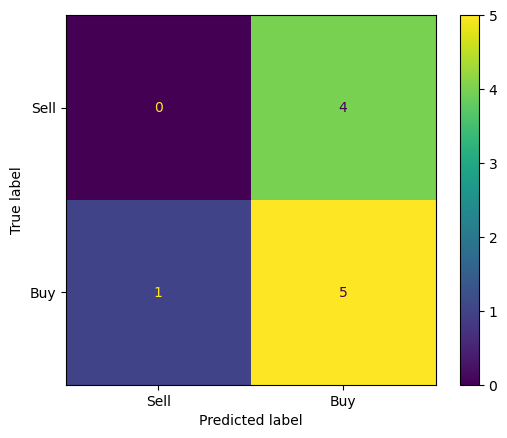

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(may7_pred['Actual_Signal'], may7_pred['Predicted_Signal'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Sell', 'Buy'])
cm_display.plot();

In [ ]:
may8_pred = add_current(df_pred_list[1])
may8_pred

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,Ticker,Close,Predicted_Price,Predicted_Returns,Predicted_Signal,Actual_Signal,Actual_Price
2024-05-07,XOM,116.169998,116.325935,-0.004756,0,0,116.150002
2024-05-07,CVX,162.669998,162.363953,0.002182,1,0,162.520004
2024-05-07,COP,123.540001,123.573448,0.000415,1,0,123.055000
2024-05-07,NEE,71.949997,71.780357,0.010141,1,1,72.839996
2024-05-07,SO,76.949997,76.752411,0.019274,1,1,77.629997
2024-05-07,EOG,130.259995,130.254654,-0.001303,0,0,129.824997
2024-05-07,DUK,102.260002,101.975563,0.016216,1,1,102.379997
2024-05-07,MPC,180.919998,180.632202,-0.008302,0,1,180.940002
2024-05-07,SLB,48.169998,48.860435,0.004379,1,0,47.849998
2024-05-07,PSX,145.210007,144.427750,0.000799,1,1,146.955002


In [ ]:
(may8_pred['Predicted_Signal'] == may8_pred['Actual_Signal']).mean()

0.6

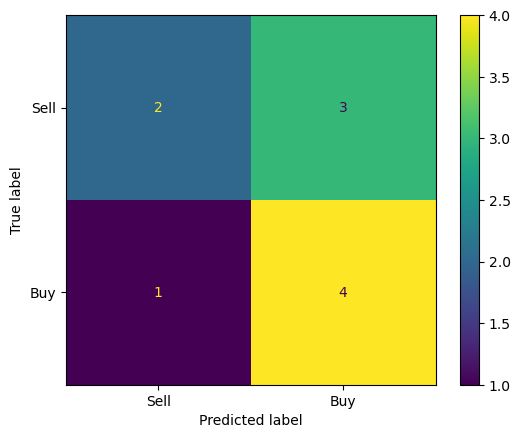

In [ ]:
cm = confusion_matrix(may8_pred['Actual_Signal'], may8_pred['Predicted_Signal'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Sell', 'Buy'])
cm_display.plot();

In [ ]:
print('change')

change


In [ ]:
def add_current(df_pred):    
    current = np.array([])
    for t in tickers:
        data = yf.download(t, period='1d')
        #data = data.loc[data.index == pd.to_datetime('2024-05-07'), :]
        current = np.append(current, data['Close'])

    df_pred['Actual_Price'] = current
    df_pred['Actual_Signal'] = (df_pred['Actual_Price'] > df_pred['Close'])*1
    return df_pred

In [ ]:
may7_pred = add_current(df_pred_list[0])
may7_pred

In [ ]:
(may7_pred['Predicted_Signal'] == may7_pred['Actual_Signal']).mean()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(may7_pred['Actual_Signal'], may7_pred['Predicted_Signal'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Sell', 'Buy'])
cm_display.plot();

In [ ]:
may8_pred = add_current(df_pred_list[1])
may8_pred

In [ ]:
(may8_pred['Predicted_Signal'] == may8_pred['Actual_Signal']).mean()

In [ ]:
cm = confusion_matrix(may8_pred['Actual_Signal'], may8_pred['Predicted_Signal'])
cm_display = ConfusionMatrixDisplay(cm, display_labels=['Sell', 'Buy'])
cm_display.plot();